In [38]:
# librerias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image

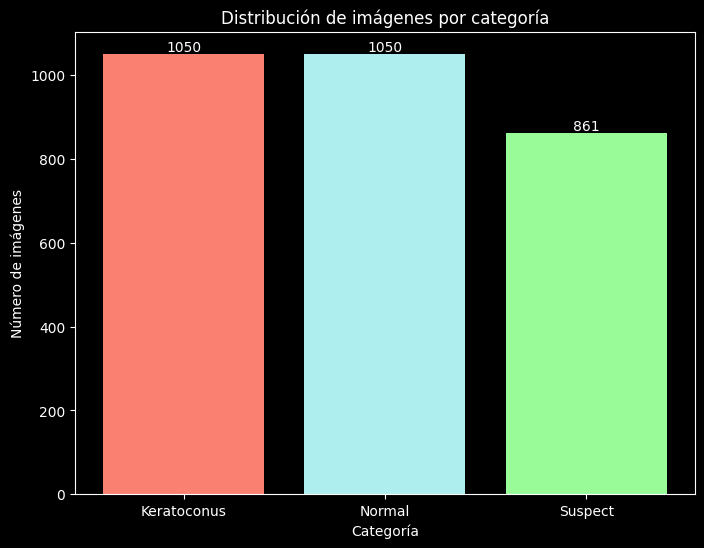

In [39]:
base_dir = r"Datos\Train"

#creamos una lista que nos permitirá ver la cantidad de imágenes por cada categoría
num_images_per_category = []

#Obtenemos la cantidad de impagenes que hay en cada una de las categorías, las cuales están como folders y vamos iterando para ver la cantidad por folder
folders = ["Keratoconus", "Normal", "Suspect"]
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    num_images_per_category.append(num_images)

#Etiquetas para las categorías, las cuales son las 4 que ya se mencionaron
labels =  ["Keratoconus", "Normal", "Suspect"]

color = ['salmon', 'paleturquoise', 'palegreen']

#gráfica de distribución para ver la cantidad
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, num_images_per_category, color=color)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
    
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.title('Distribución de imágenes por categoría')
plt.show()

In [40]:
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    print(f"Número de imágenes en '{folder}':", num_images)

Número de imágenes en 'Keratoconus': 1050
Número de imágenes en 'Normal': 1050
Número de imágenes en 'Suspect': 861


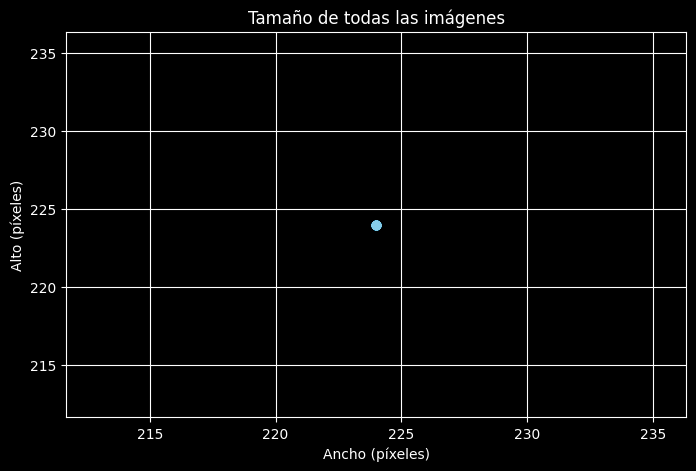

In [41]:
#Creamos una lista donde se va a estar almacenando el tamaño de las imágenes, es decir, largo y ancho
image_sizes = []


#vamos a hacer primero una iteración en cada folder, de nuevo
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    #y ahora vamos a iterar en cada imagen de cada folder, obteniendo la dirección del folder y el nombre de la imágen, realmente el nombre no es muy útil
    #pero la función necesitaba dos parámetros y ps colocamos este para no tener problemas xd
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        #una vez que se tenga una imgaen, calculamos el largo y ancho y lo agregamos a la lista creada arriba
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))

#Separar los tamaños de ancho y largo, la primera entrada es el ancho de la imagen y la segunda entrada el alto
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

#para poder ver si hay diferencias entre los tamaños, hacemos una gráfica que nos muestre todos los tamaños de todas las imágenes, pequeño spoiler de nuevo, todas son
#el mismo tamaño, es una muy buena base para empezar
plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, color='skyblue', alpha=0.5)
plt.title('Tamaño de todas las imágenes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.grid(True)
plt.show()

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# Ruta al dataset
dataset_path = r"Datos\Train"

# Crear listas para rutas y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(class_name)

# Crear un DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Dividir en conjunto de entrenamiento y prueba
train, test = train_test_split(data, stratify=data['label'], test_size=0.2, random_state=42)

In [44]:
# Generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización

# Crear generadores
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image_path',
    y_col='label',
    target_size=(250, 250),  # Reducir tamaño para mejorar velocidad
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='label',
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Found 2368 validated image filenames belonging to 3 classes.
Found 593 validated image filenames belonging to 3 classes.


In [49]:
def build_model():
    model = models.Sequential()

    # Bloque 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Bloque 4 (Capa densa)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Regularizacion
    model.add(layers.Dense(3, activation='softmax'))  # Cambiado a 3 unidades y softmax

    return model

In [50]:
model = build_model()

#Compilación del modelo
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Vemos el resumen del modelo, para asegurarnos de que esté bien
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,707 (52.92 MB)

 Trainable params: 13,872,707 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
#Detiene el modelo si considera que ya no cambia la pérdida
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#Cambia el ritmo de aprendizaje si considera que se ha estancado
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

#Crea checkpoints del mejor modelo
checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
#no supimos bien como funciona el checkpoint


In [52]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, plateau, checkpoint]
)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.4836 - loss: 2.0442
Epoch 1: val_loss improved from inf to 0.83876, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 574ms/step - accuracy: 0.4846 - loss: 2.0324 - val_accuracy: 0.5497 - val_loss: 0.8388 - learning_rate: 0.0010
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6711 - loss: 0.6842
Epoch 2: val_loss improved from 0.83876 to 0.66036, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 562ms/step - accuracy: 0.6710 - loss: 0.6842 - val_accuracy: 0.6509 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7014 - loss: 0.6105
Epoch 3: val_loss improved from 0.66036 to 0.61382, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.7014 - loss: 0.6104 - val_accuracy: 0.6830 - val_loss: 0.6138 - learning_rate: 0.0010
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0

In [53]:
#Evaluación del modelo
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7509 - loss: 0.5232
Precisión: 73.86%


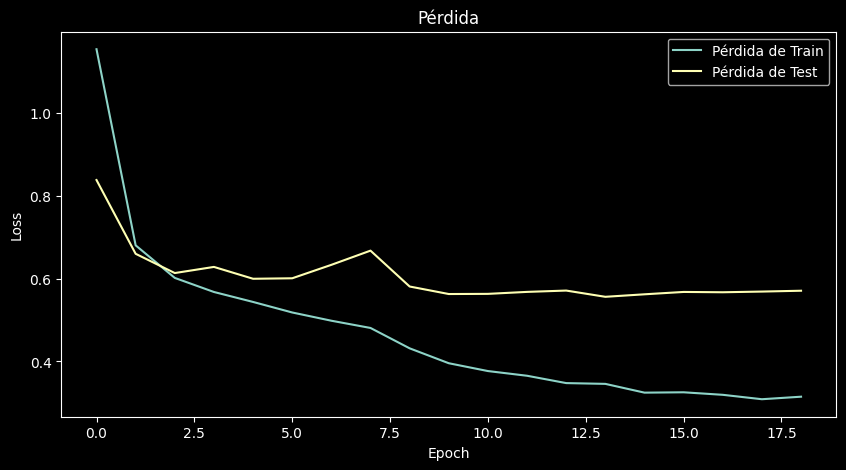

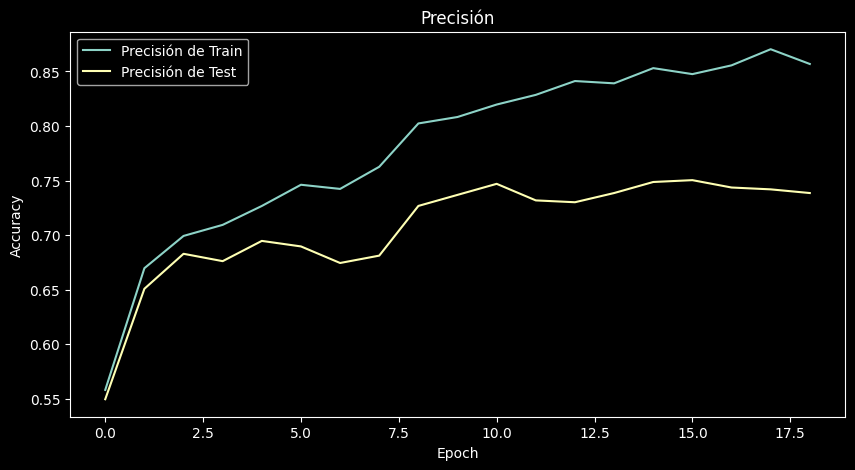

In [54]:
#Ploteamos los datos de Precisión y la Pérdida del modelo
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de Train')
plt.plot(history.history['val_loss'], label='Pérdida de Test')
plt.title('Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Precisión de Train')
plt.plot(history.history['val_accuracy'], label='Precisión de Test')
plt.title('Precisión')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score

# Obtenemos las etiquetas reales
y_test = test_generator.classes

# Generamos las predicciones (probabilidades)
y_pred_prob = model.predict(test_generator)

# Para 3 clases, tomamos la clase con mayor probabilidad
y_pred = np.argmax(y_pred_prob, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


In [2]:
# Creamos una matriz de confusión
cm = confusion_matrix(y_test, y_pred)

#Evaluamos el modelo
print("Precisión:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

#Ploteamos
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=['Keratoconus', 'Normal', 'Suspect'],
    cmap='Blues'
)

sns.heatmap(cm, annot = True, fmt = 'g')
plt.title("Matriz de Confusión - SVM")
plt.show()

NameError: name 'confusion_matrix' is not defined

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuración inicial
base_dir = r"Datos\Train"
categories = ["Keratoconus", "Normal", "Suspect"]
target_size = (250, 250)

# Carga de datos
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue
    
    print(f"Processing folder: {folder_path}")
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_resized).flatten() / 255.0  # Normalización
                data.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

Processing folder: Datos\Train\Keratoconus
Processing folder: Datos\Train\Normal
Processing folder: Datos\Train\Suspect


In [62]:
# Convertir a arrays numpy
data = np.array(data)
labels = np.array(labels)

# Verificación
if data.shape[0] == 0:
    raise ValueError("No hay imágenes en el dataset.")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Data shape: (2961, 187500)
Labels shape: (2961,)


In [63]:
# Split de datos
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Entrenar SVM
svm_model = SVC(kernel='poly', verbose = 2)
svm_model.fit(X_train, y_train)

# Evaluación
y_pred = svm_model.predict(X_test)

# Métricas para 3 clases
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, target_names=categories))

[LibSVM]

In [1]:
print(f"\nExactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'g')
plt.title("Matriz de Confusión - SVM")
plt.show()

NameError: name 'accuracy_score' is not defined